In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import time, os
import dv_processing as dv
from PIL import Image
import numpy as np

## Helper Functions


In [23]:
def getRecordingDuration(record):
    """
    Calculate the duration of a recording.

    Args:
    record (dv.io.BaseRecording): The recording object.

    Returns:
    float: The duration of the recording in seconds.
    """
    if record.isEventStreamAvailable():
        start, end = record.getTimeRange()
        duration = end - start 
    
    return duration # divide by 1e6 to convert to seconds

def getSampleDuration(sample):
    """
    Calculate the duration of a sample.

    Args:
    sample (dv.events.EventPacket): The event packet representing a sample.

    Returns:
    float: The duration of the sample in microseconds.
    """
    start, end = sample.timestamps()[0], sample.timestamps()[-1]
    duration = end - start
    return duration

def getNumEvents(sample):
    """
    Get the number of events in a sample.

    Args:
    sample (dv.events.EventPacket): The event packet representing a sample.

    Returns:
    int: The number of events in the sample.
    """
    num_events = sample.size()
    return num_events

def split_recording(record, batch_time, PRINT=False):
    """
    Split a recording into batches.

    Args:
    record (dv.io.BaseRecording): The recording object.
    batch_time (float): The duration of each batch in microseconds.
    PRINT (bool, optional): Whether to print debug information. Defaults to False.

    Returns:
    tuple: A tuple containing metadata about the recording.
    """
    record_duration = getRecordingDuration(record) # Total duration of recording
    resolution = record.getEventResolution() # Resolution of camera
    t0, t1 = record.getTimeRange() # Start & end timestamps of recording
    num_batches = record_duration // batch_time # Number of batches in recording (floored)

    if PRINT:
        print(f"Event resolution: {resolution}")
        print(f"Recording duration: {record_duration / 1e6} secs")
        print("Start timestamp:", t0)
        print("End timestamp:", t1)
    
    return (resolution, batch_time, num_batches, t0, t1)  # Return metadata

def get_batches(record, metadata):
    """
    Get batches from a recording.

    Args:
    record (dv.io.BaseRecording): The recording object.
    metadata (tuple): Metadata about the recording.

    Returns:
    pd.DataFrame: A DataFrame containing information about each batch.
    """
    _, batch_time, num_batches, t0, _ = metadata # Unpacks metadata
    cols = ['batch', 't0', 't1', 'duration', 'num_events']
    batches = pd.DataFrame(columns=cols)
    start = t0
    for i in range(num_batches):
        start, end = start, start + batch_time
        batch = record.getEventsTimeRange(start, end)
        batch_duration = getSampleDuration(batch)
        batch_numEvents = getNumEvents(batch)

        data = pd.DataFrame({'batch': [i], 
                             't0': [start], 
                             't1': [end], 
                             'duration': [batch_duration], 
                             'num_events': [batch_numEvents]})
        batches = pd.concat([batches, data])
        start += batch_time

    return batches 

def get_batch_indices(df, batches, N, PRINT=False):
    """
    Get indices of events in a batch.

    Args:
    df (pd.DataFrame): The DataFrame containing all events.
    batches (pd.DataFrame): The DataFrame containing batch information.
    N (int): The index of the batch.
    PRINT (bool, optional): Whether to print debug information. Defaults to False.

    Returns:
    pd.DataFrame: A DataFrame containing the events in the specified batch.
    """
    num_events = batches['num_events'].iloc[N] # Gets Batch N 
    
    idx0 = batches['t0'].iloc[N]
    idx1 = batches['t1'].iloc[N]
    batch = df[(df['timestamp'] > idx0) & (df['timestamp'] < idx1)]

    if PRINT:
        print(f"Number of events in Batch {N}: {num_events}")
    batch.reset_index(drop=True, inplace=True)
    return batch

def sample_2_image(sampleN, metadata):
    """
    Convert a sample to an image.

    Args:
    sampleN (pd.DataFrame): The DataFrame representing a sample.
    metadata (tuple): Metadata about the recording.

    Returns:
    np.ndarray: The image representation of the sample.
    """
    res, _, _, _, _ = metadata
    img = np.full(res, 1)
    for i in range(sampleN.shape[0]):
        x, y = sampleN['x'].iloc[i], sampleN['y'].iloc[i]
        img[x,y] = 0
    return img.T

def get_sample_freq_from_batch(batch, metadata, IMGS=False, PRINT=False):
    """
    Get the sampling frequency from a batch.

    Args:
    batch (pd.DataFrame): The DataFrame containing events in a batch.
    metadata (tuple): Metadata about the recording.
    IMGS (bool, optional): Whether to generate images. Defaults to False.
    PRINT (bool, optional): Whether to print debug information. Defaults to False.

    Returns:
    tuple: A tuple containing the sampling frequencies and images.
    """
    t0s = list(batch[batch['Unnamed: 0'] == 0].index)
    size = len(t0s)

    # Get # of events in each sample (gets sampling frequency)
    sample_freq = []
    imgs = []
    for i, t0 in enumerate(t0s):
        sample = batch.iloc[t0:t0s[i+1]] if i+1 < size else batch.iloc[t0:]
        sample_freq.append(sample.size)
        
        # Gets first image in first sample
        if IMGS:
            img = sample_2_image(sample, metadata)
            imgs.append(img)
            IMGS = False
            if PRINT: 
                print("# of events in first sample:", sample.size)
    
    if PRINT:
        print("# of samples in batch:", len(t0s))
        print("# of samples in batch (frequency check):", len(sample_freq))

    return np.array(sample_freq), np.array(imgs)

def plot_batches(batches, subject, letter):
    """
    Plot the number of events per batch.

    Args:
    batches (pd.DataFrame): The DataFrame containing batch information.
    subject (int): The subject number.
    letter (str): The letter.
    """
    plt.clf()
    plt.bar(batches['batch'], batches['num_events'], color="tab:blue")
    plt.title(f"# of Events per Batch - Subject {subject} Letter {letter}")
    plt.xlabel("Batch")
    plt.ylabel("# of Events")
    
def plot_sample_freq(sample_freq, batchN):
    """
    Plot the number of events in each sample.

    Args:
    sample_freq (np.ndarray): Array containing the number of events in each sample.
    batchN (int): The batch number.
    """

    peak_events = np.max(sample_freq)
    max_idx = np.where(sample_freq == peak_events)[0]
    print(f"Maximum # of events in batch: {peak_events} @ Sample {max_idx}")

    plt.clf()
    x = np.arange(len(sample_freq))
    plt.plot(x, sample_freq)
    plt.scatter(max_idx, peak_events, marker="o", color='tab:red')
    plt.xlabel("Sample")
    plt.ylabel("# of Events")
    plt.title(f"# of Events in Each Sample - Batch {batchN}")

### Data settings

In [12]:
# General settings
subject = 1
letter = 'f'
AEDAT = f"../data/aedat/subject{subject}/{letter}.aedat4"
CSV = f"../data/csv/subject{subject}/{letter}_events.csv"
DEBUG = True  # Debug mode - print statements

# Set time to split recording
batch_time = int(3e6) # 3e6 microseconds = 3 seconds worth of events

### Recording Metadata

This cell reads in the entire recording for the `subject` and `letter` specified. Then, it will split the reocrding into batches according the the specified `batch_time` (in microseconds). It will then store the batch metadata into a DataFrame for ease of use later.

In [13]:
recording = dv.io.MonoCameraRecording(AEDAT) # Read in whole entire recording
metadata = split_recording(recording, batch_time, DEBUG) # Track metadata - (resolution, batch_size, num_batches, t0, t1)
batches = get_batches(recording, metadata) # Creates batches from recording
df = pd.read_csv(CSV) # Read entire CSV from converted AEDAT4.0 file

batches.iloc[:5] # Print first 5 rows of DataFrame

Event resolution: (240, 180)
Recording duration: 81.728724 secs
Start timestamp: 124288256
End timestamp: 206016980


,batch,t0,t1,duration,num_events
0,0,124288256,127288256,2999999,275695
0,1,127288256,130288256,2999848,360538
0,2,130288256,133288256,2999945,323390
0,3,133288256,136288256,2999980,315518
0,4,136288256,139288256,2999948,317157


### Visualize Events Per Batch

For each batch (as seen above), you can see how the number of events varies at different points in the recording. This seems to correlate to the event distribution per sample that we see in the next section.

Text(0, 0.5, 'Number of Events')

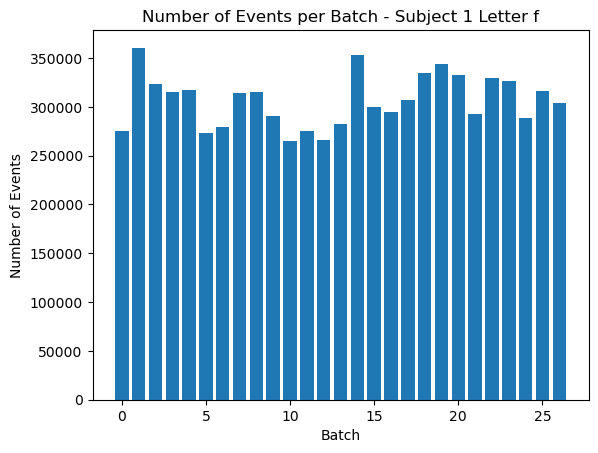

In [14]:
plt.bar(batches['batch'], batches['num_events'], color="tab:blue")
plt.title(f"Number of Events per Batch - Subject {subject} Letter {letter}")
plt.xlabel("Batch")
plt.ylabel("Number of Events")

### Visualize  Events Per Sample in Batch

For a single batch, we can observe that the number of events peaks when the subject's hand is in peak motion. Peak motion correlates to maximum kinetic energy in the hand's oscillation back and forth within the frame. Between motion inflection points (left, right), we see that there are approximately 0 events captured by the camera. This makes sense as the DVS camera will only pick up changes in pixels, so if there is no motion, then there are no events occurring.

Number of events in Batch 0: 275695
Maximum # of events in batch: 10390 @ Sample [239]


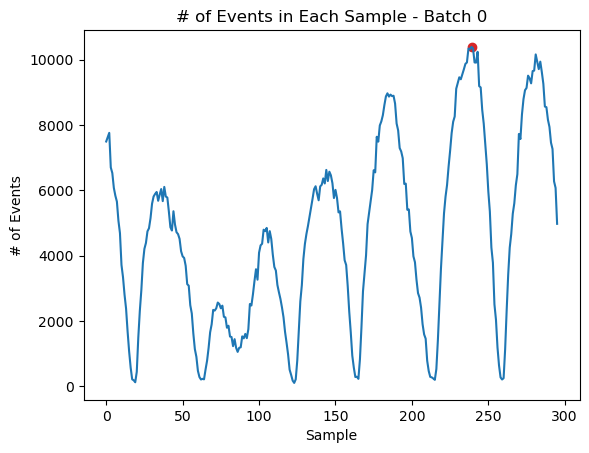

In [24]:
batchN = 0 # Toggle this to get another batch recording
batch = get_batch_indices(df, batches, batchN, DEBUG)
sample_freqN, _ = get_sample_freq_from_batch(batch, metadata)
plot_sample_freq(sample_freqN, batchN)

Number of events in Batch 6: 279386
Maximum # of events in batch: 8615 @ Sample [118]


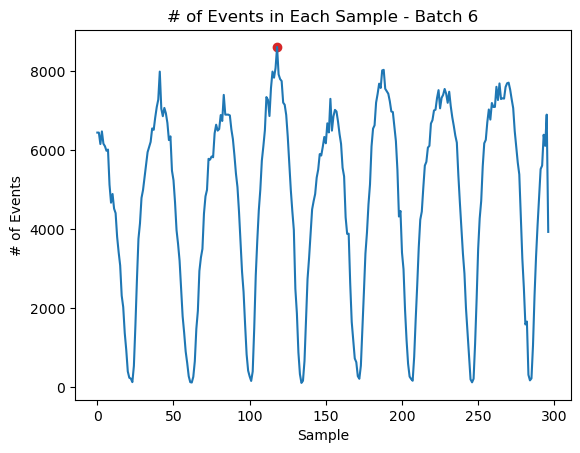

In [25]:
batchN = 6
batch = get_batch_indices(df, batches, batchN, DEBUG)
sample_freqN, _ = get_sample_freq_from_batch(batch, metadata)
plot_sample_freq(sample_freqN, batchN)

Number of events in Batch 13: 282040
Maximum # of events in batch: 10165 @ Sample [240]


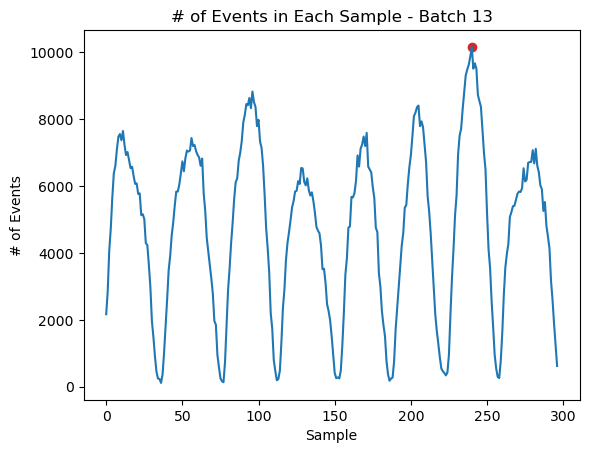

In [26]:
batchN = 13 
batch = get_batch_indices(df, batches, batchN, DEBUG)
sample_freqN, _ = get_sample_freq_from_batch(batch, metadata)
plot_sample_freq(sample_freqN, batchN)

Number of events in Batch 20: 333026
Maximum # of events in batch: 10780 @ Sample [16]


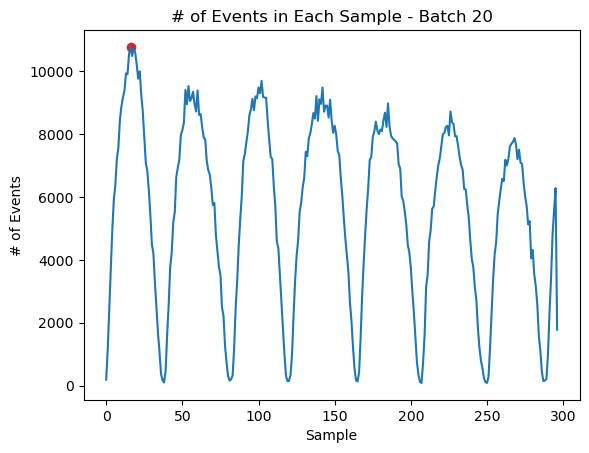

In [27]:
batchN = 20 
batch = get_batch_indices(df, batches, batchN, DEBUG)
sample_freqN, _ = get_sample_freq_from_batch(batch, metadata)
plot_sample_freq(sample_freqN, batchN)

Number of events in Batch 26: 304038
Maximum # of events in batch: 9160 @ Sample [52]


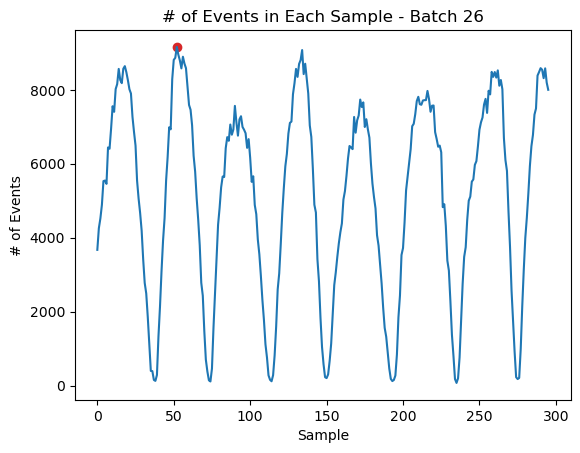

In [28]:
batchN = 26 
batch = get_batch_indices(df, batches, batchN, DEBUG)
sample_freqN, _ = get_sample_freq_from_batch(batch, metadata)
plot_sample_freq(sample_freqN, batchN)